# packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # important!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp

# Functions

In [2]:
#----------------------------------------
def AUC(y_true,y_probas):
    
#     print(y_probas)
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)


    classes = np.unique(y_true)
    probas = y_probas

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    average_score = (roc_auc[1]+roc_auc[2])/2
    return average_score


def precision(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    average_precision = {}
    for i in range(len(classes)):
        average_precision[i] = average_precision_score(y_true[:, i], probas[:, i])
        
    ave_precision = (average_precision[1]+average_precision[2])/2

    return ave_precision
    
def recall(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    recall_dict = {}
    for i in range(len(classes)):
        recall_dict[i] = recall_score(y_true[:, i], probas[:, i].round())
        
    ave_recall = (recall_dict[1]+recall_dict[2])/2

    return ave_recall


def accuracy(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    acc = {}
    for i in range(len(classes)):
        acc[i] = accuracy_score(y_true[:, i], probas[:, i].round())
        
    ave_acc = (acc[1]+acc[2])/2
    
    return ave_acc

#------------------------------------------------
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp

title_fontsize="small"
text_fontsize="small"
curves=('micro', 'macro', 'each_class')
cmap='nipy_spectral'


def plot_AUC(true_y,predict,title):


    plt.figure()
    y_true = true_y
    y_probas = predict
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    if 'micro' not in curves and 'macro' not in curves and \
            'each_class' not in curves:
        raise ValueError('Invalid argument for curves as it '
                         'only takes "micro", "macro", or "each_class"')

    classes = np.unique(y_true)
    probas = y_probas

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
       

    # Compute micro-average ROC curve and ROC area
    micro_key = 'micro'
    i = 0
    while micro_key in fpr:
        i += 1
        micro_key += str(i)

    y_true = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true = np.hstack((1 - y_true, y_true))

    fpr[micro_key], tpr[micro_key], _ = roc_curve(y_true.ravel(),
                                                  probas.ravel())
    roc_auc[micro_key] = auc(fpr[micro_key], tpr[micro_key])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[x] for x in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    macro_key = 'macro'
    i = 0
    while macro_key in fpr:
        i += 1
        macro_key += str(i)
    fpr[macro_key] = all_fpr
    tpr[macro_key] = mean_tpr
    roc_auc[macro_key] = auc(fpr[macro_key], tpr[macro_key])
   

    title = title
    plt.title(title, fontsize=title_fontsize)

#         if 'each_class' in curves:
    for i in range(len(classes)):
        color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
        plt.plot(fpr[i], tpr[i], lw=2, color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

#         if 'micro' in curves:
    plt.plot(fpr[micro_key], tpr[micro_key],
            label='micro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[micro_key]),
            color='deeppink', linestyle=':', linewidth=4)

#         if 'macro' in curves:
    plt.plot(fpr[macro_key], tpr[macro_key],
            label='macro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[macro_key]),
            color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=text_fontsize)
    plt.ylabel('True Positive Rate', fontsize=text_fontsize)
    plt.tick_params(labelsize=text_fontsize)
    plt.legend(loc='lower right', fontsize=text_fontsize)
    plt.show()


# XGBoost

In [3]:
df_nlp = pd.read_pickle('./Target_Two/prediction_df_2.pkl')
df_market = pd.read_pickle('./Target_Two/prediction_df_market2.pkl')
df_all = pd.read_pickle('./Target_Two/prediction_df_all2.pkl')

In [4]:
df_nlp.head()

,index,idel_1,buy_1,sell_1,idel_2,buy_2,sell_2,idel_3,buy_3,sell_3,idel_4,buy_4,sell_4,idel_5,buy_5,sell_5,true_value
0,0,0.014700,0.214816,0.770484,0.047294,0.296350,0.656356,0.104639,0.163815,0.731546,0.0,1.000000e+00,0.0,0.0,1.0,0.000000e+00,2.0
1,1,0.341433,0.432820,0.225747,0.404156,0.369182,0.226663,0.409817,0.369076,0.221107,0.0,0.000000e+00,1.0,0.0,0.0,1.000000e+00,0.0
2,2,0.584565,0.001502,0.413932,0.372389,0.006349,0.621261,0.403483,0.064846,0.531671,1.0,0.000000e+00,0.0,0.0,0.0,1.000000e+00,2.0
3,3,0.730207,0.094665,0.175128,0.018839,0.145678,0.835483,0.565991,0.222175,0.211834,1.0,8.327347e-30,0.0,0.0,0.0,1.000000e+00,0.0
4,4,0.357874,0.317208,0.324918,0.208816,0.659340,0.131844,0.415549,0.352196,0.232255,0.0,3.707440e-21,1.0,0.0,1.0,1.725826e-34,1.0


In [5]:
df_all.head()

,idel_1,buy_1,sell_1,idel_2,buy_2,sell_2,idel_3,buy_3,sell_3,idel_4,buy_4,sell_4,idel_5,buy_5,sell_5,true_value
0,0.000006,0.000004,0.999990,0.000518,0.000002,0.999481,0.033736,0.001664,0.964601,0.0,0.0,1.0,0.0,1.0,0.0,2.0
1,0.001134,0.688866,0.310000,0.009240,0.176313,0.814448,0.600118,0.358165,0.041717,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.999250,0.000189,0.000561,0.999920,0.000049,0.000031,0.987823,0.004419,0.007757,1.0,0.0,0.0,0.0,1.0,0.0,2.0
3,0.435402,0.094666,0.469932,0.000233,0.483896,0.515871,0.200742,0.117552,0.681706,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.817508,0.048606,0.133886,0.002462,0.986165,0.011373,0.327771,0.189246,0.482983,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## dataframe

In [14]:
result_dict = {}
auc_nlp = []
# acc_nlp = []
recall_nlp = []
pre_nlp = []
# auc_market = []
# acc_market = []
# recall_market = []
# pre_market = []
auc_all = []
# acc_all = []
recall_all = []
pre_all = []
y_true = df_nlp.as_matrix([['true_value']])

for i in range(5):
    predict_nlp = df_nlp.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    predict_market = df_market.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    predict_all = df_all.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    # ------ nlp ----------------
    auc_nlp.append(AUC(y_true,predict_nlp))
#     acc_nlp.append(accuracy(y_true,predict_nlp))
    recall_nlp.append(recall(y_true,predict_nlp))
    pre_nlp.append(precision(y_true,predict_nlp))
#     # ------ market -----------------
#     auc_market.append(AUC(y_true,predict_market))
#     acc_market.append(accuracy(y_true,predict_market))
#     recall_market.append(recall(y_true,predict_market))
#     pre_market.append(precision(y_true,predict_market))
     # ------ all-----------------
    auc_all.append(AUC(y_true,predict_all))
#     acc_all.append(accuracy(y_true,predict_all))
    recall_all.append(recall(y_true,predict_all))
    pre_all.append(precision(y_true,predict_all))
    
result_dict['AUC_nlp'] = auc_nlp
# result_dict['accuracy_nlp'] = acc_nlp
result_dict['precision_nlp'] = pre_nlp
result_dict['recall_nlp'] = recall_nlp

# result_dict['AUC_market'] = auc_market
# result_dict['accuracy_market'] = acc_market
# result_dict['recall_market'] = recall_market
# result_dict['precision_market'] = pre_market
result_dict['AUC_all'] = auc_all
# result_dict['accuracy_all'] = acc_all
result_dict['precision_all'] = pre_all
result_dict['recall_all'] = recall_all


In [15]:
pd.DataFrame.from_dict(result_dict)

,AUC_all,AUC_nlp,precision_all,precision_nlp,recall_all,recall_nlp
0,0.545370,0.505518,0.332184,0.310720,0.330014,0.169299
1,0.588154,0.512649,0.371798,0.309228,0.416552,0.201236
2,0.567968,0.506989,0.368414,0.310945,0.308379,0.131181
3,0.548840,0.509134,0.330688,0.309071,0.395604,0.285371
4,0.526341,0.519308,0.318945,0.316267,0.355426,0.509272


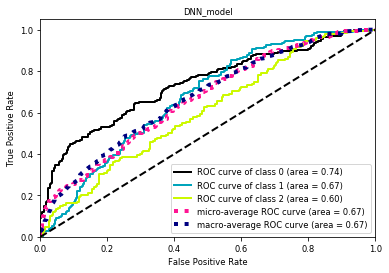

,AUC,accuracy,precision,recall
0,0.638548,0.695212,0.406495,0.056338


In [13]:
#============================================ neural network===================================
result_dict = {}
Auc = []
acc = []
Recall = []
Pre = []


pre = pd.read_pickle('./Target_Two/predictions.pickle').query('variable == "pred"')
pre = pre.loc[:,~pre.columns.duplicated()]
predicts = pre.as_matrix([['target_0_vb200_vf3_volatility_VWAP_200_0',
      'target_1_vb200_vf3_volatility_VWAP_200_0',
      'target_-1_vb200_vf3_volatility_VWAP_200_0']])
true = pd.read_pickle('./Target_Two/predictions.pickle').query('variable == "true"')
# drop duplicates
true = true.loc[:,~true.columns.duplicated()]
y_true = true.as_matrix([['target_0_vb200_vf3_volatility_VWAP_200_0',
  'target_1_vb200_vf3_volatility_VWAP_200_0',
  'target_-1_vb200_vf3_volatility_VWAP_200_0']])
y_true = np.argmax(y_true,axis=1)
plot_AUC(y_true,predicts,'DNN_model')

Auc.append(AUC(y_true,predicts))
acc.append(accuracy(y_true,predicts))
Recall.append(recall(y_true,predicts))
Pre.append(precision(y_true,predicts))

result_dict['AUC'] = Auc
result_dict['accuracy'] = acc
result_dict['recall'] = Recall
result_dict['precision'] = Pre
pd.DataFrame.from_dict(result_dict)



## Plot

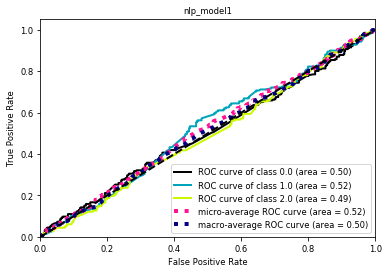

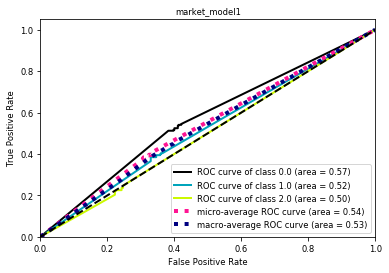

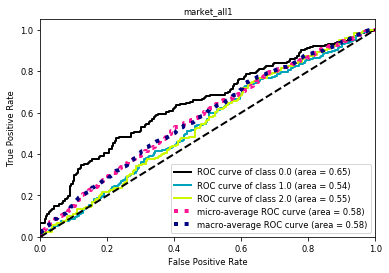

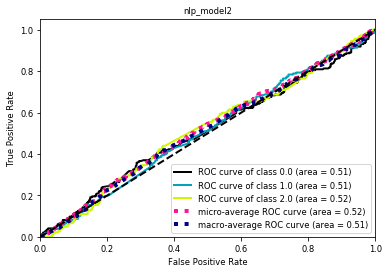

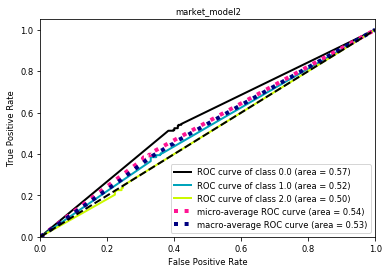

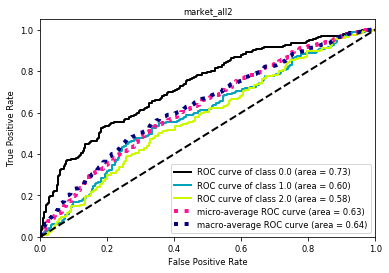

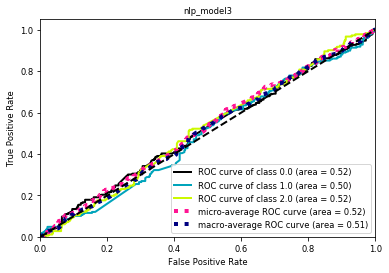

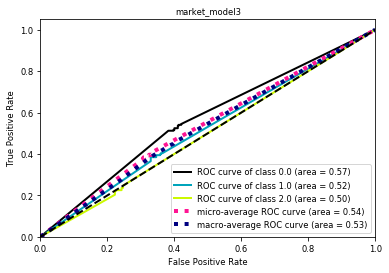

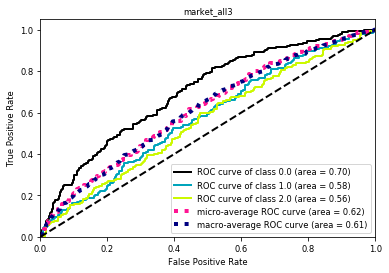

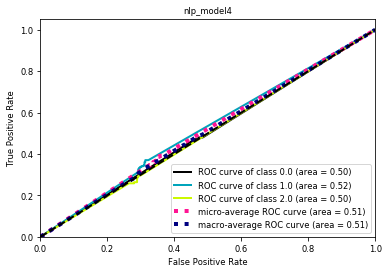

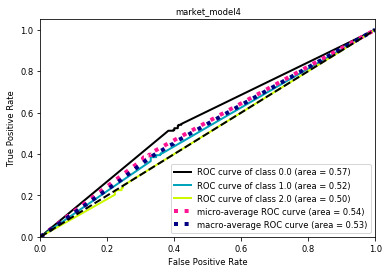

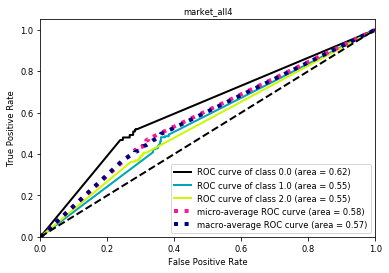

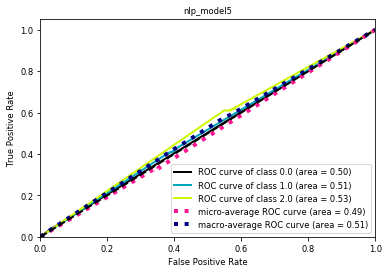

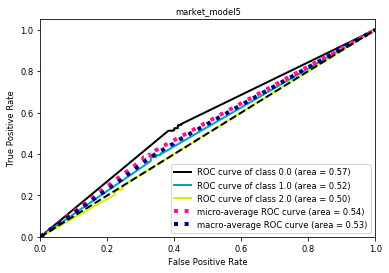

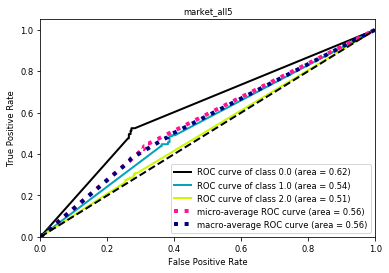

In [8]:
y_true = df_nlp.as_matrix([['true_value']])
for i in range(5):
    predict_nlp = df_nlp.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    predict_all = df_all.as_matrix([['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)]])
    plot_AUC(y_true,predict_nlp,'nlp_model{}'.format(i+1))
    plot_AUC(y_true,predict_market,'market_model{}'.format(i+1))
    plot_AUC(y_true,predict_all,'market_all{}'.format(i+1))